# Comparative Object Permanence Measurement Layouts

Authors: K. Voudouris, J. Burden, J. Hernández-Orallo

## INIT

In [1]:
!pip install pymc
!pip install numpy
!pip install arviz
!pip install erroranalysis

In [36]:
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import erroranalysis as ea
import matplotlib.pyplot as plt
import gc
from google.colab import files
import math
import seaborn as sns
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


## Load Data

In [62]:
agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_agents_wide.csv?token=GHSAT0AAAAAACEGARGRAOJ6GRN7H7S7UMKUZG6PU2Q'
agent_data = pd.read_csv(agents_url)

children_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_children_wide.csv?token=GHSAT0AAAAAACEGARGQMDG5YSDZU6AWS4BWZG6PVJA'
children_data = pd.read_csv(children_url)


## Define the Measurement Layout

In [69]:
## Helper functions

def logistic(x):
  return 1 / (1 + np.exp(-x))

def visualAcuityLOMargin(ability, goalSmallness): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  return ability - goalSmallness   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

def flatNavMargin(ability, distanceToGoal, numTurns): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
  return ability - (distanceToGoal * numTurns)   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def objPermanenceLOMargin(ability, allocentricOcclusion, cvChick, pctb, lightsOut, distanceToGoal, numPositions, maxPermAbility, lightsOutPenalisation, uniformAbilitySlack): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
  assert lightsOutPenalisation < uniformAbilitySlack and lightsOutPenalisation > 1, "Penalisation for lights out must be lower than the slack on abilities."
  OPPerformance = ability  - ((distanceToGoal * numPositions)*(lightsOut*lightsOutPenalisation))
  return maxPermAbility-((maxPermAbility-OPPerformance)*((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb))) #multiply by a factor that introduces whether the instance is a an OP CV task or an OP PCTB task (indepedent, so ((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb)) should be 0 or 1)


In [123]:
def SetupModel(taskResultsAll, uniformAbilitySlack, agent_type, agent_name = None, sample = 500):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """


  if agent_type == "agent":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults[agent_name]
  elif agent_type == "child":
    taskResults = taskResultsAll.dropna(subset = ['success'])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults['success']
  else:
    print("Agent not recognised. Quitting.")
    return



  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = taskResults["cityBlockDistanceToGoal"].max()
  maxTurns = taskResults["minNumTurnsRequired"].max()
  maxChoices = taskResults["numChoices"].max()
  maxGoalSize = taskResults["mainGoalSize"].max()
  maxPermAbility = maxDistance * maxChoices * uniformAbilitySlack
  #maxMemoryAbility = maxDistance * uniformAbilitySlack
  m = pm.Model()
  with m:

    objPermAbility = pm.Uniform("objPermAbility", 0, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = 0
    abilityMax["objPermAbility"] = maxPermAbility

    #memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    #abilityMin["memoryAbility"] = 0
    #abilityMax["memoryAbility"] = maxMemoryAbility

    #Visual acuity
    maxVisualAcuityAbility = maxGoalSize* uniformAbilitySlack
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", 0, maxVisualAcuityAbility)
    abilityMin["visualAcuityAbility"] = 0
    abilityMax["visualAcuityAbility"] = maxVisualAcuityAbility

    # Flat Navigation Ability
    flatNavAbility = pm.Uniform("flatNavAbility", 0, maxDistance*maxTurns)      # how much navigation is involved, i.e, how far away and how circuitous is the path to the goal?
    abilityMin["flatNavAbility"] =0
    abilityMax["flatNavAbility"] = maxDistance*maxTurns

    # Lava Ability
    lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    # Ramp Ability
    rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    abilityMin["rampAbility"] = 0
    abilityMax["rampAbility"] = 1

    # Goal Right Ability
    rightAbility = pm.Beta("rightAbility", 1, 1)
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 1

    # Goal Left Ability
    leftAbility = pm.Beta("leftAbility", 1, 1)
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 1

    # Goal Ahead Ability
    aheadAbility = pm.Beta("aheadAbility", 1, 1)
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 1

    # # CV Chick Ability
    # CVChickAbility = pm.Beta("CVChickAbility", 1, 1)
    # abilityMin["CVChickAbility"] = 0
    # abilityMax["CVChickAbility"] = 1

    # # PCTB Ability
    # PCTBAbility = pm.Beta("PCTBAbility", 1, 1)
    # abilityMin["PCTBAbility"] = 0
    # abilityMax["PCTBAbility"] = 1



    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values)
    rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values)
    #numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values)
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values)
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values)
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"])
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"])
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"])
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"])
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"])
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"])
    CVTest = pm.MutableData("CVChickTest", taskResults["cvchickTask"])
    PCTBTest = pm.MutableData("PCTBTest", taskResults["pctbTask"])

    ## Margins

    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSmallness)))

    rightP = pm.Deterministic("rightPerformance", SimplePrMargin(rightAbility, goalRight))
    aheadP = pm.Deterministic("aheadPerformance", SimplePrMargin(aheadAbility, goalAhead))
    leftP = pm.Deterministic("leftPerformance", SimplePrMargin(leftAbility, goalLeft))

    flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns)))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))

    rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    #cvchickP = pm.Deterministic("cvChickP", SimplePrMargin(CVChickAbility, CVTest))
    #pctbP = pm.Deterministic("pctbP", SimplePrMargin(PCTBAbility, PCTBTest))

    navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP)) #, visualAcuityP))

    OPLOM = objPermanenceLOMargin(objPermAbility, opTest, CVTest, PCTBTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.2), uniformAbilitySlack=uniformAbilitySlack)

    objPermP = pm.Deterministic("objPermP", logistic(OPLOM))

    finalP = pm.Deterministic("finalP", (objPermP * navP * visualAcuityP))

    taskPerformance = pm.Bernoulli("taskPerformance", finalP, observed=results)

  pm.model_graph.model_to_graphviz(m)

  return m, abilityMin, abilityMax

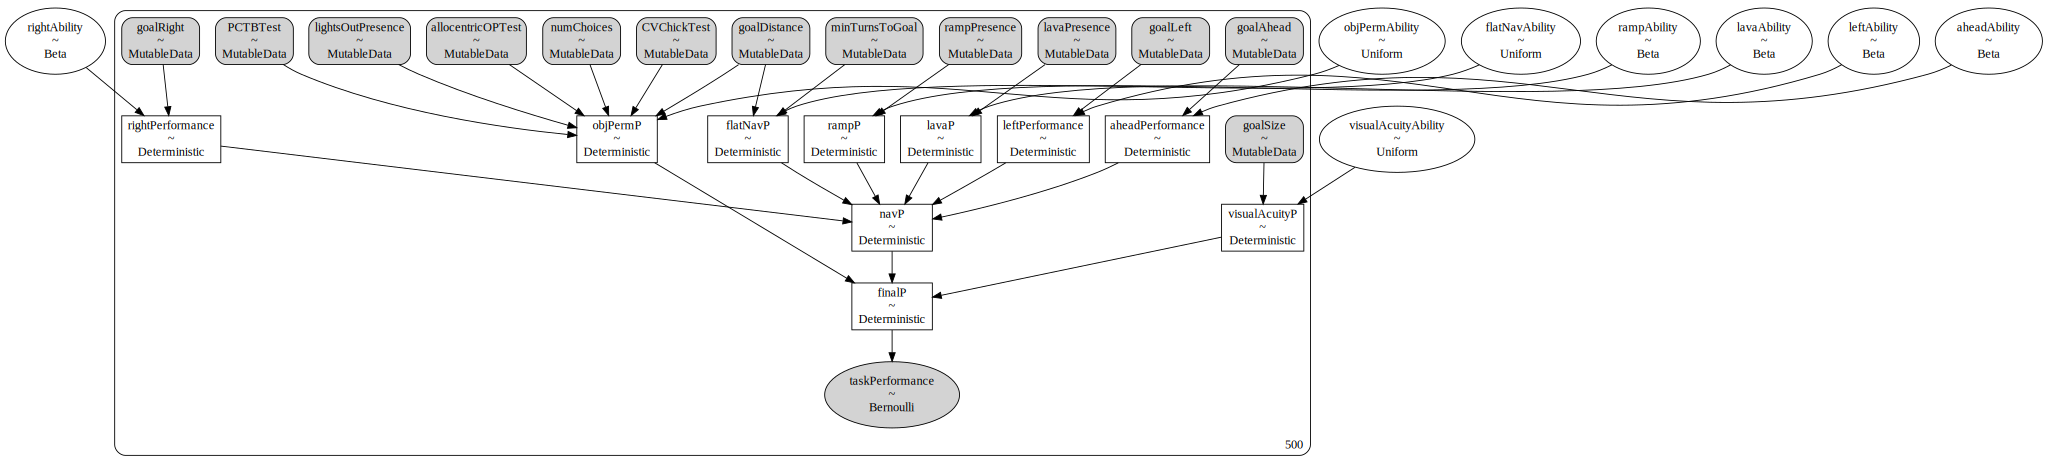

In [124]:
from IPython.display import Image
import graphviz

m, min, max = SetupModel(agent_data, uniformAbilitySlack=1.4, agent_type='agent', agent_name="Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761")
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
#gv.render(directory='viz')
#Image("viz/Digraph.gv.png")
gv

In [125]:
with m:
    agentData = pm.sample(200, target_accept=0.95) #Might need more samples to converge

ValueError: ignored

In [75]:
agentData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [121]:
# A function for pulling out the means and standard deviations for abilities of interest
def analyzeAgentResults(agentName, agentData, abilitiesToShow):

  abilityMeans = [] # empty list to add in ability means to
  abilitySDs = []
  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior

    posteriorMean = float(np.mean(agentData['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(agentData['posterior'][a])) #calculate posterior sd
    abilityMeans.append(posteriorMean)
    abilitySDs.append(posteriorSD)

  return abilityMeans, abilitySDs

# A function for padding the testing data with 0s for prediction
def pad(testingData, trainingDataSize):
    return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))

# A function for making predictions based on a fitted measurement layout
def predict(m, agentData, dfTest, agent, len_training):
  with m:
    # set the data for prediction
    pm.set_data({"lavaPresence": pad(dfTest["lavaPresence"], len_training)})
    pm.set_data({"lightsOutPresence": pad(dfTest["lightsOutPresence"], len_training)})
    pm.set_data({"rampPresence": pad(dfTest["taskCriticalRampPresence"], len_training)})
    pm.set_data({"numChoices": pad(dfTest["numChoices"], len_training)})
    pm.set_data({"minTurnsToGoal": pad(dfTest["minNumTurnsRequired"], len_training)})
    pm.set_data({"goalDistance": pad(dfTest["cityBlockDistanceToGoal"], len_training)})
    pm.set_data({"goalSize": pad(dfTest["mainGoalSize"], len_training)})
    pm.set_data({"goalRight": pad(dfTest["goalRightRelToStart"], len_training)})
    pm.set_data({"goalAhead": pad(dfTest["goalCentreRelToStart"], len_training)})
    pm.set_data({"goalLeft": pad(dfTest["goalLeftRelToStart"], len_training)})
    pm.set_data({"CVChickTest": pad(dfTest["cvchickTask"], len_training)})
    pm.set_data({"PCTBTest": pad(dfTest["pctbTask"], len_training)})
    pm.set_data({"allocentricOPTest": pad(dfTest["goalBecomesAllocentricallyOccluded"], len_training)})

    predictions=pm.sample_posterior_predictive(agentData, var_names=["finalP"], return_inferencedata=False,predictions=True,extend_inferencedata=False)
    predictionChainRuns =predictions["finalP"][:,:,0:len(dfTest)]
    predictionsInstance = np.mean(predictionChainRuns, (0,1))

    return predictionsInstance,  dfTest[agent].to_numpy()


def brierScore(preds, outs):
    return 1/len(preds) * sum( (preds-outs)**2 )

def brierDecomp(preds, outs):

  brier= 1/len(preds) * sum( (preds-outs)**2 )
  ## bin predictions
  bins = np.linspace(0,1,11)
  binCenters = (bins[:-1] +bins[1:]) /2
  binPredInds = np.digitize(preds,binCenters)
  binnedPreds = bins[binPredInds]

  binTrueFreqs = np.zeros(10)
  binPredFreqs = np.zeros(10)
  binCounts = np.zeros(10)

  for i in range(10):
      idx = (preds >= bins[i]) & (preds < bins[i+1])

      binTrueFreqs[i] = np.sum(outs[idx])/np.sum(idx) if np.sum(idx) > 0 else 0
     # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
      binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
      binCounts[i] = np.sum(idx)

  calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(binCounts)>0 else 0
  refinement = np.sum(binCounts * (binTrueFreqs *(1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(binCounts)> 0 else 0
  # Compute refinement component
  #refinement = brier - calibration
  return brier, calibration, refinement



In [93]:
from sklearn.model_selection import train_test_split

agents_training, agents_test = train_test_split(agent_data, test_size=0.2)
children_training, children_test = train_test_split(children_data, test_size=0.2)


In [126]:
m, min, max = SetupModel(agents_training, uniformAbilitySlack=1.4, agent_type='agent', agent_name="Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761", sample = 200)

In [127]:
with m:
    agentData = pm.sample(500, target_accept=0.95) #Might need more samples to converge

In [103]:
abilitiesToShow = ["objPermAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "rampAbility", "leftAbility", "aheadAbility", "rightAbility"]
agentName = "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761"

abilitiesIncludingSuccess = abilitiesToShow + [agentName]



mu, sd  = analyzeAgentResults(agentName, agentData, abilitiesToShow)

In [ ]:
agents_test['min']

In [128]:
agentData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [129]:
#taskResults = agent_data[agentName] #Grab the column of results for that agent

m, min, max = SetupModel(agents_test, uniformAbilitySlack=1.4, agent_type='agent', agent_name="Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761")

mu, sd  = analyzeAgentResults(agentName, agentData, abilitiesToShow)
predictions, testOutputs = predict(m, agentData, agents_test, agentName, len(agents_training[agentName]))

<ipython-input-121-e49df24b29d0>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-121-e49df24b29d0>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-121-e49df24b29d0>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))
<ipython-input-121-e49df24b29d0>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return testingData.append(pd.

In [137]:

abilityDF = pd.DataFrame( {'Ability': abilitiesIncludingSuccess})
meansDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
stdDevDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
modelBrierScores = []
aggregateBrierScores = []
modelCalibrations = []
aggregateCalibrations = []
modelRefinements = []
aggregateRefinements = []

agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(agent_data[agentName]), len(testOutputs)), testOutputs)
aggregateBrierScores.append(agentAggBrierScore)
aggregateCalibrations.append(agentAggCalibration)
aggregateRefinements.append(agentAggRefinement)
modelBrierScores.append(agentBrierScore)
modelCalibrations.append(agentCalibration)
modelRefinements.append(agentRefinement)
abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]

In [141]:
print(predictions)

[2.08519117e-02 2.18606104e-01 2.08519117e-02 5.32809810e-03
 1.09456975e-02 2.43901070e-01 1.94129445e-02 6.19128451e-03
 2.43900541e-01 2.08519117e-02 1.94129445e-02 1.06273132e-02
 4.21869659e-02 1.31348532e-02 1.13450837e-62 5.75706621e-02
 1.94129445e-02 6.01966834e-02 3.10516739e-02 1.50387697e-03
 5.32809810e-03 1.57186921e-02 1.37436365e-02 4.78258607e-02
 1.05982545e-02 1.05982545e-02 1.05982545e-02 5.75706621e-02
 5.32809810e-03 5.34939313e-02 5.89141671e-02 7.19565662e-02
 4.86077744e-02 7.42420806e-03 1.90726463e-01 2.83307383e-01
 1.16777661e-02 2.08519117e-02 5.75706621e-02 4.35210477e-02
 1.05982545e-02 1.84897073e-03 5.75704897e-02 7.21525507e-03
 4.35210477e-02 5.92844813e-03 1.84897073e-03 5.71660004e-02
 2.06470804e-02 1.64843931e-02 4.78258607e-02 1.31458381e-02
 8.91070485e-02 6.38370546e-02 7.36726669e-03 1.52239107e-02
 1.37436365e-02 7.56299437e-02 4.04176077e-02 2.67096191e-03
 1.48488371e-06 8.27603670e-03 5.43232947e-02 5.39642264e-03
 6.15502227e-02 1.522391

In [135]:
brierDF = pd.DataFrame({"Model Brier Score":modelBrierScores, "Aggregate Brier Scores": aggregateBrierScores, "Model Calibration": modelCalibrations, "Aggregate Calibration":aggregateCalibrations, "Model Refinement":modelRefinements, "Aggregate Refinement":aggregateRefinements,  "Model Better? (Based on Brier Score)":np.array(modelBrierScores)<np.array(aggregateBrierScores), "Success Score":meansDF.iloc[9][1:]})

IndexError: ignored

In [ ]:
taskResults = agent_data[agentName] #Grab the column of results for that agent
print(agent_data)
print(np.mean(taskResults)) #print mean performance for the agent across all tasks
m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults

mu, sd  = analyzeAgentResults(agentName, agentData)
predictions, testOutputs = predict(m, agentData, agents_test[agentName], len(agents_test[agentName]))
agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(taskResults), len(testOutputs)), testOutputs)
aggregateBrierScores.append(agentAggBrierScore)
aggregateCalibrations.append(agentAggCalibration)
aggregateRefinements.append(agentAggRefinement)
modelBrierScores.append(agentBrierScore)
modelCalibrations.append(agentCalibration)
modelRefinements.append(agentRefinement)
abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]

In [77]:
mu

[957.8211534433694,
 430.0174585649903,
 3.34278797072004,
 0.2704157242555865,
 0.26270885137591565,
 0.5113058990175643,
 0.6354539815603858,
 0.332816016360568]

In [78]:
sd

[585.1943134691745,
 371.9360326942805,
 0.946923322663028,
 0.12109347701954246,
 0.10101198292049572,
 0.1981752512026943,
 0.1917904912669476,
 0.14964102966304701]

In [61]:
max

{'objPermAbility': 1982.3999999999999,
 'visualAcuityAbility': 7.0,
 'flatNavAbility': 1534.0,
 'lavaAbility': 1,
 'rampAbility': 1,
 'rightAbility': 1,
 'leftAbility': 1,
 'aheadAbility': 1}

In [ ]:
##### Sample results for each agent using the model defined in the function above.
allAgentData = [] #blank list for entering the outputs of the pm sampling for each agent
agentNames = [] #blank list for the agent names
agentColList = agentCols.tolist()
print(agentColList)
numAgents = len(agentColList) #Number of agents, replace with a small number for testing to save time
print(numAgents)
#numAgents=3
abilitiesToShow = ["objPermAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "platformAbility", "rampAbility", "memoryAbility", "rightLeftBias", "noisePar"]

abilitiesIncludingSuccess = abilitiesToShow + ["Success"]
abilityDF = pd.DataFrame( {'Ability': abilitiesIncludingSuccess})
meansDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
stdDevDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
modelBrierScores = []
aggregateBrierScores = []
modelCalibrations = []
aggregateCalibrations = []
modelRefinements = []
aggregateRefinements = []


for i in range(numAgents): # Iterate through each agent.
  agent = agentCols[i] #Get the agent name
  taskResults = df[agent] #Grab the column of results for that agent
  print(agent)
  print(np.mean(taskResults)) #print mean performance for the agent across all tasks
  m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults

  #Now sample based on this agent's performance
  with m:
    agentData = pm.sample(1000, target_accept=0.95) #Might need more samples to converge

  mu, sd  = analyzeAgentResults(agent, agentData)
  predictions, testOutputs = predict(m, agentData, dfTest, agent)
  agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
  agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(taskResults), len(testOutputs)), testOutputs)
  aggregateBrierScores.append(agentAggBrierScore)
  aggregateCalibrations.append(agentAggCalibration)
  aggregateRefinements.append(agentAggRefinement)
  modelBrierScores.append(agentBrierScore)
  modelCalibrations.append(agentCalibration)
  modelRefinements.append(agentRefinement)
  abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
  abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]


  abilityMeans = abilityMeans + [str(round(np.mean(taskResults),2))+" "]
  abilitySDs = abilitySDs + [str(round(np.std(taskResults), 2))]
  abilityDF[agent] = list(zip(abilityMeans, abilitySDs))
  mu=mu+[np.mean(taskResults)]
  sd=sd+[np.std(taskResults)]
  meansDF[agent]=[round(mu_i,2) for mu_i in mu]
  stdDevDF[agent]=[round(sd_i,2) for sd_i in sd]